----
### 04. Modeling

**Objective:**  to experiment with a range of machine learning models, starting with a simple Logistic Regression baseline  and move to a more powerful algorithms to improve predictive performance in identifying fraudulent transactions. Challenged by the severe class imbalance within the dataset.

---

In [1]:
from src.data_loader import load_data

raw_data = load_data("../data/creditcard.csv")

raw_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [2]:
from sklearn.model_selection import train_test_split

X = raw_data.iloc[:, :-1]
y = raw_data.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify= y, random_state=3479)

In [3]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((227845, 30), (227845,), (56962, 30), (56962,))

-----
### 4.1 Baseline Logistic Regression Model

In [4]:
%%time

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from src.feature_engineering import FeatureEngineer
import pandas as pd

categorical_features = ["Time_segment"]

preprocessor = ColumnTransformer(
    transformers=[
        ("categorical", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ],
    # keep all other columns (eg numeric features)
    remainder="passthrough"
)

# Final pipeline
pipeline_lr = Pipeline([
    ("feature_engineer", FeatureEngineer()),
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(class_weight="balanced", random_state=3479, max_iter=5000))
])

pipeline_lr.fit(X_train, y_train)

# Convert pipeline steps to a Pandas DataFrame
pipeline_df = pd.DataFrame(
    [(i+1, name, type(step).__name__) for i, (name, step) in enumerate(pipeline_lr.steps)],
    columns=['Step', 'Name', 'Type']
)

pipeline_df.style.hide(axis="index")
# Display without the DataFrame index

CPU times: total: 14.9 s
Wall time: 4.22 s


Step,Name,Type
1,feature_engineer,FeatureEngineer
2,preprocessor,ColumnTransformer
3,classifier,LogisticRegression


In [5]:
y_pred_lr = pipeline_lr.predict(X_test)

-----
#### Evaluation

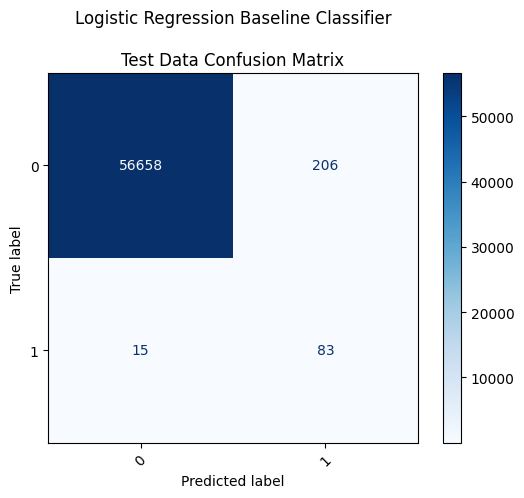

In [6]:
from src.model import evaluate_model

lr_metrics = evaluate_model(pipeline_lr, X_test, y_test, model_name="Logistic Regression Baseline Classifier", print_c_matrix=True)

In [7]:
lr_metrics

,precision,recall,f1-score,Balanced Accuracy,PR AUC,ROC AUC
0,1.000,0.996,0.998,0.922,0.719,0.978
1,0.287,0.847,0.429,0.922,0.719,0.978



`Interim outcome:`
The Baseline Logistic regression achieved a PR-AUC of 0.71, which is strong starting point for this severe class-imbalance . However, the model shows poor precision of for the positive class (Class Fraud) of 0.29 --> indicating many false positives. This underscores the need for a more  powerful models.

`Considerations moving forward:`

- I will apply balanced class weight
- `I will utilize CatBoost and LightGBM which are gradient-boosted tree models very powerful for tabular data, handle imbalanced classes well.`
- -----

### 4.2 CatBoost Classifier (Gradient Boosted Tree model)

CatBoost Classifier is a model based on gradient-boosted sequential decision trees (weak learners) where each tree corrects the previous errors. This model  has been selected to be the first advanced Classifier due to:

- Native handling of categorical data.
- Strength in handling minority classes through (`class_weights`, and `auto_class_weights = balanced`).
- Requires minimum fine-tuning.



In [8]:
%%time
# 1. Importing CatBoost model
from catboost import CatBoostClassifier

# 2. Build the pipeline
categorical_features = ['Time_segment']

# Final pipeline
catboost_model = Pipeline([
    ("feature_engineer", FeatureEngineer()),
    ("classifier", CatBoostClassifier(
        iterations=1000,
        # Number of boosted trees CatBoost will build.
        auto_class_weights="Balanced",
        # Automatically increases the importance of the minority class.
        # Handles severe class imbalance without manually computing weights.
        learning_rate=0.01,
        depth=6,
        # The depth of each decision tree.
        cat_features=categorical_features,
        eval_metric="PRAUC",
        # The metric CatBoost optimizes during training.
        verbose=0 #silent training
    ))
])

# 3. Train/ fit the model
catboost_model.fit(X_train, y_train)

# Convert pipeline steps to a Pandas DataFrame
pipeline_df = pd.DataFrame(
    [(i+1, name, type(step).__name__) for i, (name, step) in enumerate(catboost_model.steps)],
    columns=['Step', 'Name', 'Type']
)

pipeline_df.style.hide(axis="index")
# Display without the DataFrame index

CPU times: total: 7min 53s
Wall time: 1min 20s


Step,Name,Type
1,feature_engineer,FeatureEngineer
2,classifier,CatBoostClassifier


#### Evaluation

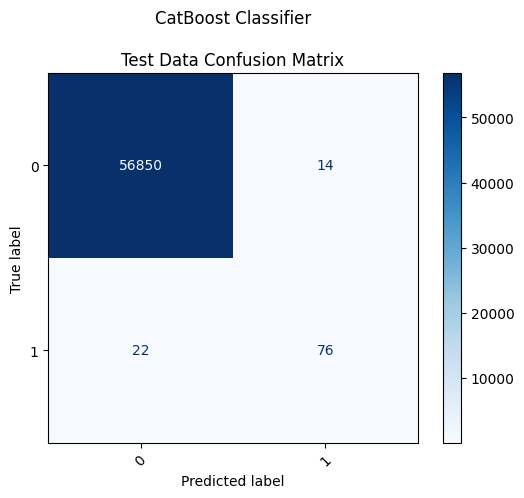

In [9]:
catboost_metrics = evaluate_model(catboost_model, X_test, y_test, model_name="CatBoost Classifier", print_c_matrix=True)

In [10]:
catboost_metrics

,precision,recall,f1-score,Balanced Accuracy,PR AUC,ROC AUC
0,1.000,1.000,1.000,0.888,0.808,0.973
1,0.844,0.776,0.809,0.888,0.808,0.973


`Interim outcome:`
The `CatBoost(Gradient Boosted Tree)` model outperformed the baseline model (i.e. Logistic regression) achieving PR AUC of ~0.81 with higher precision for the positive class  (class fraud).

-------
### 4.3 LightGBM (Gradient Boosted Tree model)
LightGBM has similar strong traits e.g. handles severe class imbalance and categorical features. Moreover, it is fast on large datasets.

In [11]:
%%time

from lightgbm import LGBMClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

categorical_features = ['Time_segment']

# encode categorical features
preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
], remainder="passthrough")  # keep numeric features as they are

lightgbm_model = Pipeline([
    ("Feature_engineer", FeatureEngineer()),
    ("Preprocessor", preprocessor),
    ("Classifier", LGBMClassifier(
        n_estimators=1000,
        class_weight="balanced", # handles class imbalance
        learning_rate=0.01,
        max_depth=6,
        random_state=3479,
        verbose=0
    ))
])

lightgbm_model.fit(X_train, y_train)

# Convert pipeline steps to a Pandas DataFrame
pipeline_df = pd.DataFrame(
    [(i+1, name, type(step).__name__) for i, (name, step) in enumerate(lightgbm_model.steps)],
    columns=['Step', 'Name', 'Type']
)

pipeline_df.style.hide(axis="index")
# Display without the DataFrame index

CPU times: total: 29.5 s
Wall time: 6.46 s


Step,Name,Type
1,Feature_engineer,FeatureEngineer
2,Preprocessor,ColumnTransformer
3,Classifier,LGBMClassifier


C:\Users\Mohanad\Local Git Repositories\Projects\fraud-detection-credit-card\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\Mohanad\Local Git Repositories\Projects\fraud-detection-credit-card\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


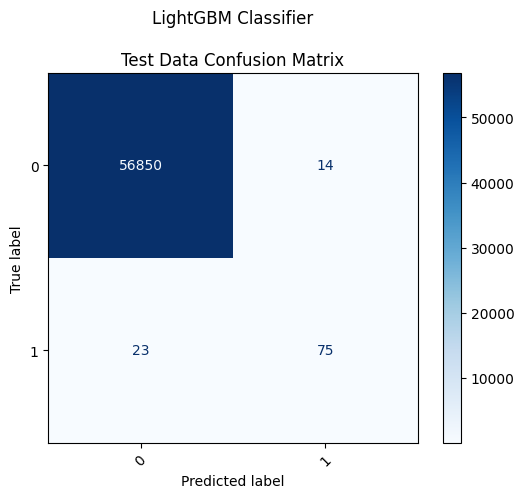

In [12]:
lightgbm_metrics = evaluate_model(lightgbm_model, X_test, y_test, model_name="LightGBM Classifier", print_c_matrix=True)

In [19]:
lightgbm_metrics

,precision,recall,f1-score,Balanced Accuracy,PR AUC,ROC AUC
0,1.000,1.000,1.000,0.883,0.814,0.971
1,0.843,0.765,0.802,0.883,0.814,0.971


-----
### 4.4 Random Forest Classifier

(Aggregation-based ensemble algorithm and easier interpretability)

In [39]:
%%time

from sklearn.ensemble import RandomForestClassifier
categorical_features = ['Time_segment']

preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
], remainder="passthrough")

rf_model = Pipeline([
    ("feature_engineer", FeatureEngineer()),
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(
        max_depth=10,
        min_samples_leaf=10,
        random_state=3479,
        n_estimators=1000,
        class_weight="balanced", # handles class imbalance
        n_jobs=-1, # use all CPU cores
    ))
])

rf_model.fit(X_train, y_train)

# Convert pipeline steps to a Pandas DataFrame
pipeline_df = pd.DataFrame(
    [(i+1, name, type(step).__name__) for i, (name, step) in enumerate(rf_model.steps)],
    columns=['Step', 'Name', 'Type']
)
pipeline_df.style.hide(axis="index")

CPU times: total: 18min 45s
Wall time: 1min 42s


Step,Name,Type
1,feature_engineer,FeatureEngineer
2,preprocessor,ColumnTransformer
3,classifier,RandomForestClassifier


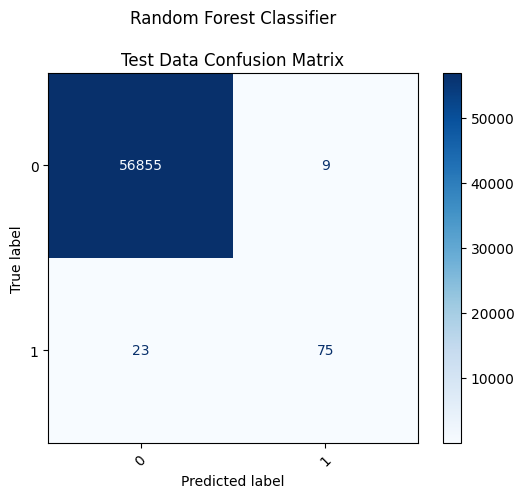

In [40]:
rf_metrics = evaluate_model(rf_model, X_test, y_test, model_name="Random Forest Classifier", print_c_matrix=True)

In [41]:
rf_metrics

,precision,recall,f1-score,Balanced Accuracy,PR AUC,ROC AUC
0,1.000,1.000,1.000,0.883,0.826,0.964
1,0.893,0.765,0.824,0.883,0.826,0.964


---
### 4.5 Performance Comparison Focused on Positive/Fraud Class

In [42]:
from src.model import compare_models

compare_models({"Logistic Regression (Baseline)":lr_metrics,"CatBoost Classifier": catboost_metrics,"LightGBM Classifier": lightgbm_metrics,"Random Forest Classifier": rf_metrics})

,precision,recall,f1-score,Balanced Accuracy,PR AUC,ROC AUC
Logistic Regression (Baseline),0.287,0.847,0.429,0.922,0.719,0.978
CatBoost Classifier,0.844,0.776,0.809,0.888,0.808,0.973
LightGBM Classifier,0.843,0.765,0.802,0.883,0.814,0.971
Random Forest Classifier,0.893,0.765,0.824,0.883,0.826,0.964


`Analysis:`

1 - Random Forest Classifier shows the highest PR AUC (0.826), with the highest F1-score (0.824).

2 - LightGBM Classifier achieves a comparable PR AUC (0.814), with a slightly lower F1-score (0.802).

3 - CatBoost is marginally behind these two models with PR AUC of (0.808)

Based on this assessment, I will fine-tune the top two models (Random Forest and LightGBM) to determine which one performs best for the positive class (fraud).

-----
### 4.6 Hyperparameters Fine-Tuning
